In [5]:
import pandas as pd 
import numpy as np
import pyjags as pj
import arviz as az
from scipy import stats
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from datetime import datetime
import seaborn as sns
import sys
sys.path.append('../Advanced-statistcs/')
from analysis import Analysis

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image 


%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

#  Analytical solution of the SCIR model at low fraction of infected individuals

The SCIR model includes the usual states of an SIR model plus a new class C for individuals
sent to confinement that are susceptible but not infected.

In [9]:
# data until 17 may
url = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/covid-19-es.csv"
# data until 31 march
url_confirmed = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/confirmed-march31.csv"
url_recovered = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/recovered-march31.csv"
url_death = "https://raw.githubusercontent.com/mariocastro73/predictability/master/datasets/deaths-march31.csv"

df = pd.read_csv(url, keep_date_col=True)
df = df[~df.isna().any(axis=1)].reset_index(drop=True)
df['Day'] = pd.date_range(start="2020.01.31", end="2020.05.17")
df['Day'] = pd.to_datetime(df.Day, format='%Y-%m-%d').dt.strftime('%Y.%m.%d')

df.loc[(df.Day <= "2020.03.31") & (df.Day >= "2020.02.27"), ['Death', 'Confirmed', 'Recovered']] = np.column_stack([pd.read_csv(url_death)['Spain'],
                                                                        pd.read_csv(url_confirmed)['Spain'],
                                                                        pd.read_csv(url_recovered)['Spain']])
df['Confirmed'] = df.Confirmed - df.Recovered - df.Death
df['Confirmed_smooth'] = df.Confirmed.rolling(2, min_periods=1).mean()
df['Recovered_Death'] = (df.Recovered + df.Death).diff().fillna(0) # (daily derivative)
df['Recovered_Death_smooth'] = df.Recovered_Death.rolling(2, min_periods=1).mean()

df = df[df.Day >= '2020.02.28'].reset_index(drop=True)
df

,Day,Death,Confirmed,Recovered,Confirmed_smooth,Recovered_Death,Recovered_Death_smooth
0,2020.02.28,0.0,32.0,0.0,24.0,0.0,-1.5
1,2020.02.29,0.0,44.0,0.0,38.0,0.0,0.0
2,2020.03.01,0.0,66.0,0.0,55.0,0.0,0.0
3,2020.03.02,0.0,114.0,0.0,90.0,0.0,0.0
4,2020.03.03,0.0,150.0,0.0,132.0,0.0,0.0
...,...,...,...,...,...,...,...
75,2020.05.13,27091.0,60777.0,140823.0,61570.0,2025.0,2019.0
76,2020.05.14,27308.0,58858.0,143374.0,59817.5,2768.0,2396.5
77,2020.05.15,27449.0,57951.0,144783.0,58404.5,1550.0,2159.0
78,2020.05.16,27549.0,56703.0,146446.0,57327.0,1763.0,1656.5


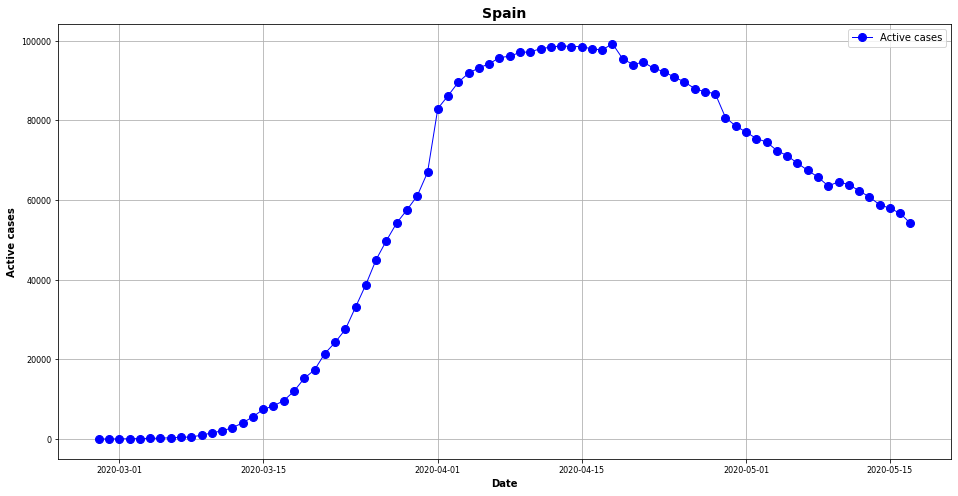

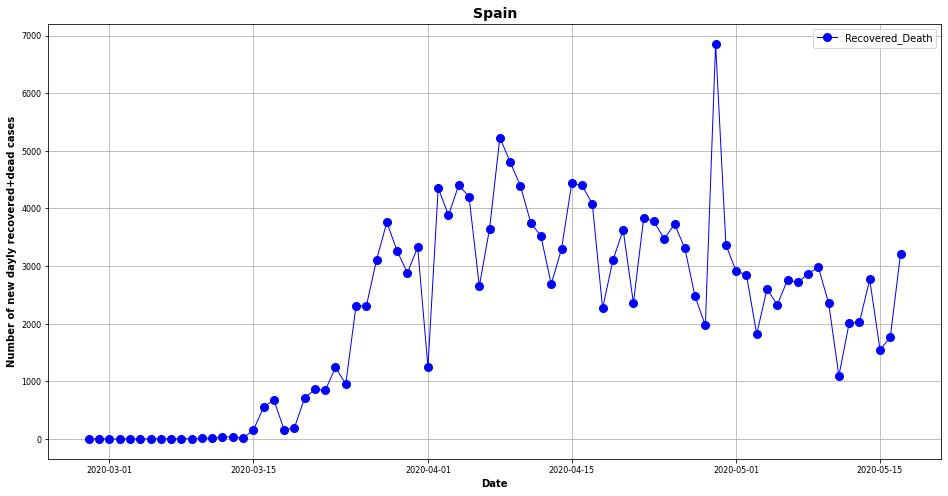

In [10]:
# save fgure with plot from january
plt.plot(pd.to_datetime(df.Day), df.Confirmed, 'bo-', lw=1, label='Active cases')
#plt.plot(pd.to_datetime(df.Day), df.Confirmed_smooth, 'r', lw=2, label='Active cases (2-days rolling average)')
#ymin, ymax = plt.ylim()
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Spain', weight='bold', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("active_cases_data_Spain.png", quality=100, transparent=True, dpi=400)
plt.show()


plt.plot(pd.to_datetime(df.Day), df.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
#plt.plot(pd.to_datetime(df.Day), df.Recovered_Death_smooth, 'r', lw=2, label='Recovered_Death (2-days rolling average)')
#ymin, ymax = plt.ylim()
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.02.28']), 0, ymax, color='r')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.03.31']), 0, ymax, color='g')
#plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.04.18']), 0, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Spain', weight='bold', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("recovered_death_data_Spain.png", quality=100, transparent=True, dpi=400)

## Fit ending before peak data
fit from 2020-02-27 to 2020-03-29 with confinement measure aplied on 2020-03-11

In [ ]:
# instantiating an analysis object
analysis_esp = Analysis(date=df['Day'].to_numpy(),
                        confirmed=df['Confirmed'].to_numpy(),
                        recovered_death=df['Recovered_Death'].to_numpy(),
                        quarantine='2020.03.09',
                        last_data='2020.03.29',
                        last_projection='2020.05.17',
                        peak='2020.04.18',
                        beta=[0,1],
                        rmu=[0,1],
                        q=[0,5],
                        p=[0,5],
                        tauI=[0.01, 0.01],
                        tauX=[0.01, 0.01],
                        country='Spain')

In [ ]:
%%time
# call sampler analysis' method
analysis_esp.sampler(nchains=12, nthreads=12, niter=10000, burn_in=0.5)

analysis_esp.summary

Where

$$\hat{R} = \sqrt{\frac{\hat{V}}{W}}$$ is the **potential scale reduction factor**
<br>
<br>
- &emsp; **W** is the within-chain variance (mean of variance of each chain),
<br>
- &emsp; $\hat{V}$ is the variance between multiple chains.
<br>
<br>
This is the potential scale reduction factor, which converges to unity when each of the traces is a sample from the target posterior.
<br>
Values greater than one indicate that one or more chains have not yet converged.
<br> The simulation was runned until the $\hat{R}$ of each parameter was < 1.01.

In [ ]:
analysis_esp.plot_summary()

In [ ]:
analysis_esp.autocorr_fit_plot(var='rmu')

In [ ]:
analysis_esp.autocorrelation_time_plot()
analysis_esp.times.max()*50, analysis_esp.times.max()*1000, analysis_esp.times.min()

In [ ]:
analysis_esp.plot_results(Y=True, observed=True)

In [ ]:
analysis_esp.plot_results(Z=True, observed=True)

## Fit ending after peak data for the daily number of active cases

In [ ]:
analysis_esp_2 = Analysis(date=df['Day'].to_numpy(),
                          confirmed=df['Confirmed'].to_numpy(),
                          recovered_death=df['Recovered_Death'].to_numpy(),
                          quarantine='2020.03.09',
                          last_data='2020.04.18',
                          last_projection='2020.05.17',
                          peak='2020.04.18',
                          beta=[0,1],
                          rmu=[0,1],
                          q=[0,5],
                          p=[0,5],
                          tauI=[0.01, 0.01],
                          tauX=[0.01, 0.01],
                          country='Spain')

In [ ]:
%%time
# call sampler analysis' method
analysis_esp_2.sampler(nchains=12, nthreads=12, niter=30000, burn_in=0.5)

In [ ]:
%%time

analysis_esp_2.summary

In [ ]:
%%time

analysis_esp_2.plot_summary()

In [ ]:
analysis_esp.autocorr_fit_plot(var='rmu')

In [ ]:
analysis_esp_2.autocorrelation_time_plot()
analysis_esp_2.times.max()*50, analysis_esp_2.times.max()*1000

In [ ]:
analysis_esp_2.plot_results(Y=True, observed=True)


In [ ]:
analysis_esp_2.plot_results(Z=True, observed=True)

# Dataset Italy
The data is taken from Protezione Civile site, starting from 2020.02.24.

In [12]:
# dataset active cases
# all data from 2020-02-28 to today
url_ita = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento" + \
            "-nazionale/dpc-covid19-ita-andamento-nazionale.csv"

df1 = pd.read_csv(url_ita)[['data', 'totale_casi', 'dimessi_guariti', 'deceduti']]
df1.columns = ['Day', 'Confirmed', 'Recovered', 'Death']
df1['Day'] = pd.to_datetime(df1.Day, format='%Y.%m.%d').dt.strftime('%Y.%m.%d')


df1['Confirmed'] = df1.Confirmed - df1.Recovered - df1.Death
df1['Confirmed_smooth'] = df1.Confirmed.rolling(7, min_periods=1).mean()
df1['Recovered_Death'] = (df1.Recovered + df1.Death).diff().fillna(0) # (daily derivative)
df1['Recovered_Death_smooth'] = df1.Recovered_Death.rolling(7, min_periods=1).mean()


df1

,Day,Confirmed,Recovered,Death,Confirmed_smooth,Recovered_Death,Recovered_Death_smooth
0,2020.02.24,221,1,7,221.000000,0.0,0.000000
1,2020.02.25,311,1,10,266.000000,3.0,1.500000
2,2020.02.26,385,3,12,305.666667,4.0,2.333333
3,2020.02.27,588,45,17,376.250000,47.0,13.500000
4,2020.02.28,821,46,21,465.200000,5.0,11.800000
...,...,...,...,...,...,...,...
463,2021.06.01,225751,3868332,126221,242739.857143,10406.0,9258.000000
464,2021.06.02,210050,3886867,126283,235600.000000,18597.0,10193.142857
465,2021.06.03,205562,3893259,126342,228795.571429,6451.0,9546.285714
466,2021.06.04,200192,3901112,126415,222213.000000,7926.0,9155.714286


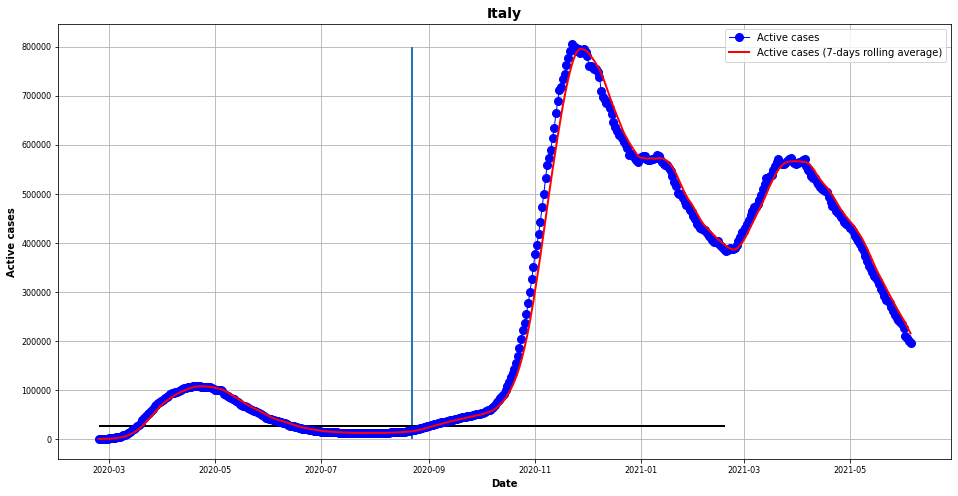

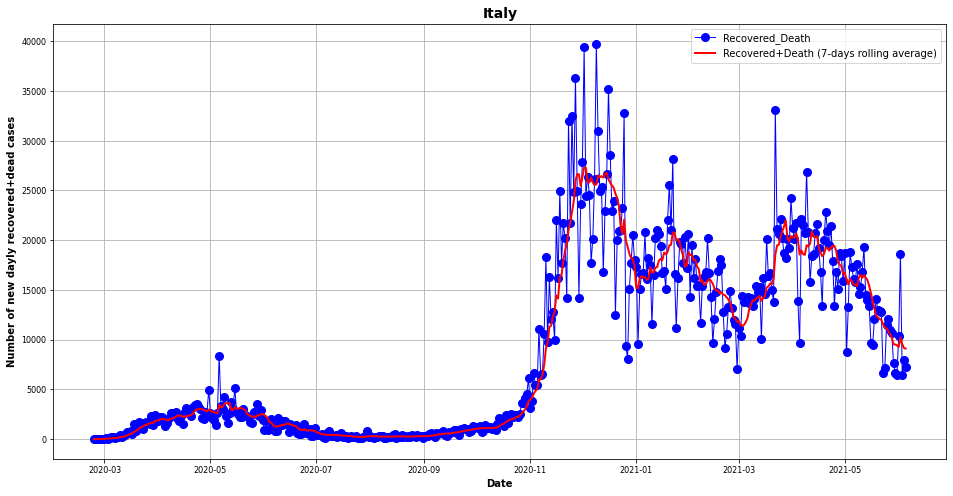

In [13]:
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed, 'bo-', lw=1, label='Active cases')
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed_smooth, 'r', lw=2, label='Active cases (7-days rolling average)')
plt.vlines(pd.to_datetime(df1.Day[180]), 0, 800000)
plt.hlines(df1.loc[224, 'Confirmed_smooth'] / 2, pd.to_datetime(df1.Day[0]), pd.to_datetime(df1.Day[360]), color='k')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("active_data_Italy.png", quality=100, transparent=True, dpi=400)
plt.show()


plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death_smooth, 'r', lw=2, label='Recovered+Death (7-days rolling average)')
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("recovered_death_data_Italy.png", quality=100, transparent=True, dpi=400)

## Fit ending before peak data for the daily number of active cases
fit from 2020-02-24 to 2020-03-29 with confinement measure aplied on 2020-03-09

In [ ]:
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed, 'bo-', lw=1, label='Active cases')
plt.plot(pd.to_datetime(df1.Day), df1.Confirmed_smooth, 'r', lw=2, label='Active cases (7-days rolling average)')
plt.vlines(pd.to_datetime(df1.Day[180]), 0, 800000)
plt.hlines(df1.loc[224, 'Confirmed_smooth'] / 2, pd.to_datetime(df1.Day[0]), pd.to_datetime(df1.Day[360]), color='k')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("active_data_Italy.png", quality=100, transparent=True, dpi=400)
plt.show()


plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death, 'bo-', lw=1, label='Recovered_Death')
plt.plot(pd.to_datetime(df1.Day), df1.Recovered_Death_smooth, 'r', lw=2, label='Recovered+Death (7-days rolling average)')
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("recovered_death_data_Italy.png", quality=100, transparent=True, dpi=400)

In [ ]:
%%time
analysis_ita.sampler(nchains=12, nthreads=12, niter=50000, burn_in=0.5)

In [ ]:
%%time

analysis_ita.summary

In [ ]:
%%time

analysis_ita.plot_summary()

In [ ]:
analysis_ita.autocorrelation_time_plot()
analysis_ita.times.max()*50, analysis_ita.times.max()*1000